In [1]:
import pandas as pd
import numpy as np

# Считываем данные
data = pd.read_csv('data.csv', sep=',', error_bad_lines=False)
data_positive=data[data.Rating >= 3]
data_negative=data[data.Rating < 3]
# Формируем сбалансированный датасет
sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['Review'].values[:sample_size],
                           data_negative['Review'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

C:\CONDA\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
import re

def preprocess_text(text):
    text=str(text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [13]:
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Считываем файл с предобработанными отзывами
data = gensim.models.word2vec.LineSentence('1.txt')
# Обучаем модель 
model = Word2Vec(data, vector_size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())
model.save("model.w2v")

2022-12-15 22:53:09,512 : INFO : collecting all words and their counts
2022-12-15 22:53:21,373 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-12-15 22:53:28,471 : INFO : collected 217552 word types from a corpus of 14565199 raw words and 1457 sentences
2022-12-15 22:53:28,479 : INFO : Creating a fresh vocabulary
2022-12-15 22:53:29,070 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 109761 unique words (50.45% of original 217552, drops 107791)', 'datetime': '2022-12-15T22:53:29.066018', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-12-15 22:53:29,072 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 14408857 word corpus (98.93% of original 14565199, drops 156342)', 'datetime': '2022-12-15T22:53:29.072017', 'gensim': '4.2.0', 'python': '3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1

2022-12-15 22:54:33,050 : INFO : EPOCH 3 - PROGRESS: at 0.07% examples, 2661 words/s, in_qsize 16, out_qsize 0
2022-12-15 22:54:34,061 : INFO : EPOCH 3 - PROGRESS: at 6.38% examples, 186559 words/s, in_qsize 15, out_qsize 0
2022-12-15 22:54:35,108 : INFO : EPOCH 3 - PROGRESS: at 12.42% examples, 290389 words/s, in_qsize 16, out_qsize 0
2022-12-15 22:54:36,113 : INFO : EPOCH 3 - PROGRESS: at 18.39% examples, 360608 words/s, in_qsize 14, out_qsize 1
2022-12-15 22:54:37,128 : INFO : EPOCH 3 - PROGRESS: at 24.91% examples, 420275 words/s, in_qsize 14, out_qsize 1
2022-12-15 22:54:38,147 : INFO : EPOCH 3 - PROGRESS: at 31.23% examples, 461844 words/s, in_qsize 15, out_qsize 0
2022-12-15 22:54:39,149 : INFO : EPOCH 3 - PROGRESS: at 37.95% examples, 500456 words/s, in_qsize 14, out_qsize 1
2022-12-15 22:54:40,163 : INFO : EPOCH 3 - PROGRESS: at 44.82% examples, 532863 words/s, in_qsize 14, out_qsize 1
2022-12-15 22:54:41,167 : INFO : EPOCH 3 - PROGRESS: at 51.54% examples, 558512 words/s, in_

In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# Высота матрицы (максимальное количество слов)
SENTENCE_LENGTH = 100
# Размер словаря
NUM = 10000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

# Cоздаем и обучаем токенизатор
tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

# Отображаем каждый текст в массив идентификаторов токенов
x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [5]:
# Загружаем модель и создаем embedding матрицу 
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('model.w2v')
DIM = w2v_model.vector_size
embedding_matrix = np.zeros((NUM, DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in list(w2v_model.wv.index_to_key):
        embedding_matrix[i] = w2v_model.wv[word]

In [6]:
# Инициируем embedding-слой весами, полученными при обучении Word2Vec.
from keras.layers import Input
from keras.layers import Embedding

review_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
review_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(review_input)

In [8]:
# Введем метрики precision (точность), recall (полнота) и F1 (среднее гармоническое из двух).
from keras import backend as K


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     2000000     ['input_1[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 100, 200)     0           ['embedding[0][0]']              
                                                                                                  
 conv1d_10 (Conv1D)             (None, 99, 1)        401         ['dropout_2[0][0]']              
                                                                                            

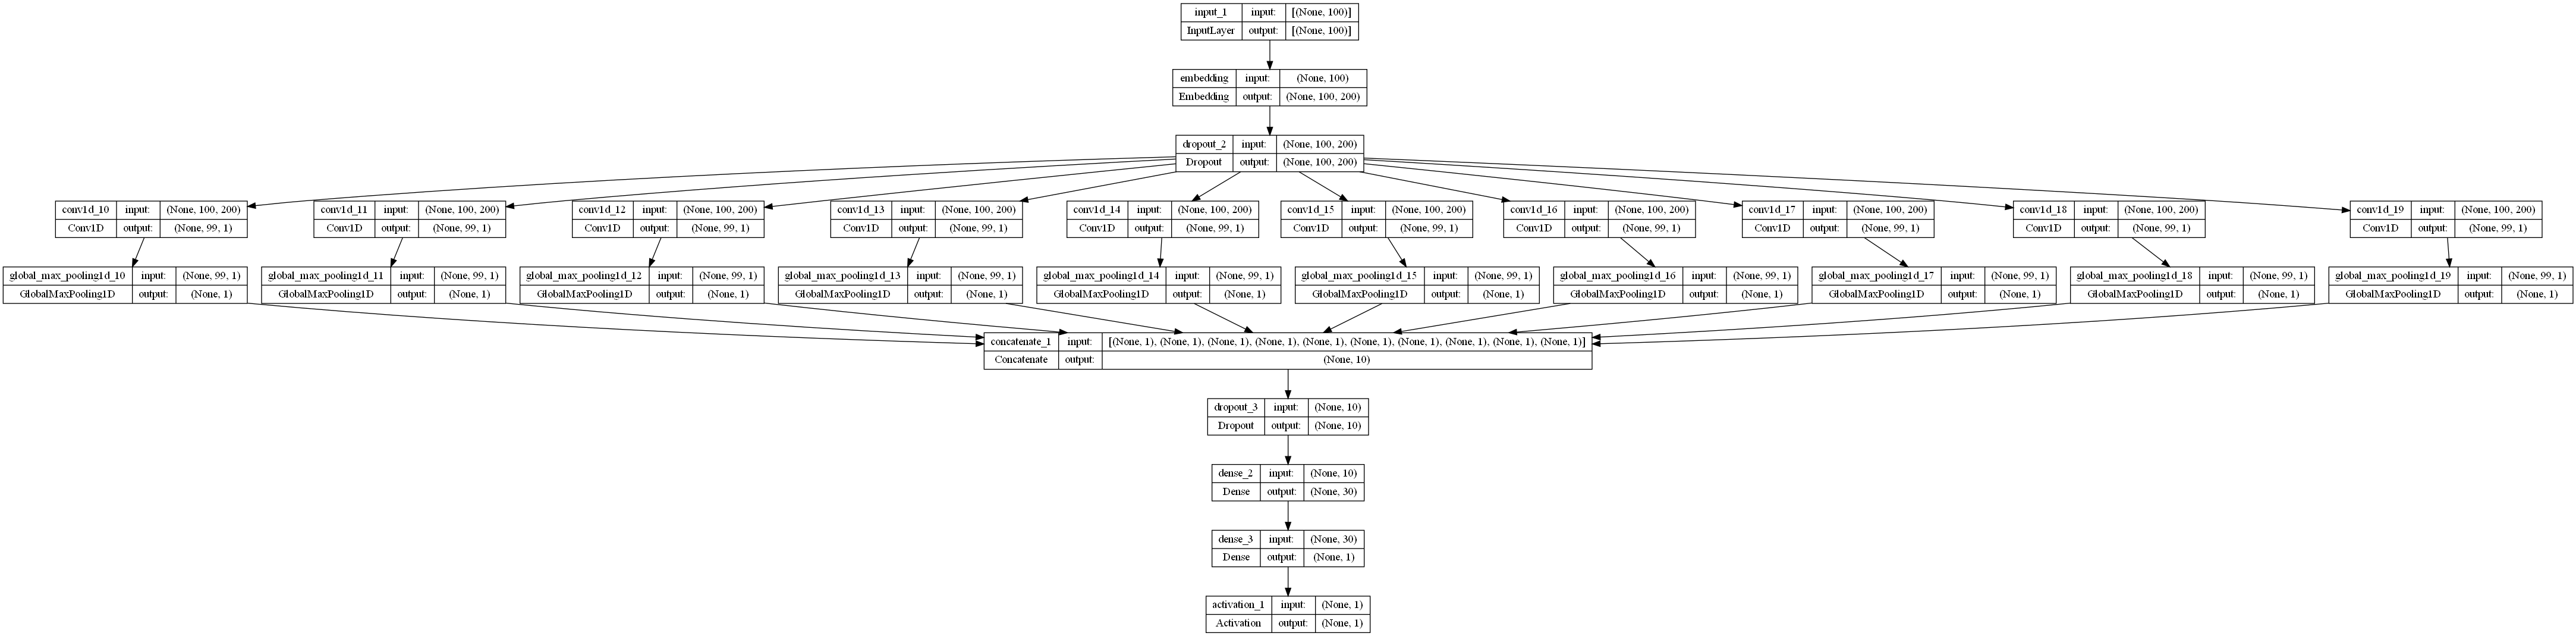

In [9]:
# Создаем сверточную сеть для обработки биграмм
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.utils import plot_model

branches = []
# Добавляем dropout-регуляризацию
x = Dropout(0.2)(review_encoder)

for size, filters_count in [(2, 10)]:
    for i in range(filters_count):
        # Добавляем слой свертки
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        # Добавляем слой субдискретизации
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
# Конкатенируем карты признаков
x = concatenate(branches, axis=1)
# Добавляем dropout-регуляризацию
#x = LSTM(64, return_sequences=True)(x)
#x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[review_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5",
                             monitor='val_f1', save_best_only=True, mode='max', save_freq='epoch')
history = model.fit(np.array(x_train_seq), np.array(y_train), batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/10
2635/2635 [==============================] - 177s 66ms/step - loss: 0.5318 - precision: 0.7354 - recall: 0.7258 - f1: 0.7225 - val_loss: 0.4268 - val_precision: 0.8201 - val_recall: 0.7879 - val_f1: 0.7984
Epoch 2/10
2635/2635 [==============================] - 166s 63ms/step - loss: 0.4547 - precision: 0.7972 - recall: 0.7720 - f1: 0.7780 - val_loss: 0.4223 - val_precision: 0.8194 - val_recall: 0.8006 - val_f1: 0.8049
Epoch 3/10
2635/2635 [==============================] - 175s 66ms/step - loss: 0.4419 - precision: 0.8067 - recall: 0.7779 - f1: 0.7861 - val_loss: 0.4039 - val_precision: 0.8430 - val_recall: 0.7900 - val_f1: 0.8105
Epoch 4/10
2635/2635 [==============================] - 218s 83ms/step - loss: 0.4361 - precision: 0.8099 - recall: 0.7812 - f1: 0.7894 - val_loss: 0.4078 - val_precision: 0.8546 - val_recall: 0.7747 - val_f1: 0.8075
Epoch 5/10
2635/2635 [==============================] - 191s 72ms/step - loss: 0.4312 - precision: 0.8123 - recall: 0.7856 - f1: 0.7

[0.7354164719581604, 0.7971702218055725, 0.8067026138305664, 0.8098548650741577, 0.8122765421867371, 0.814808189868927, 0.816556453704834, 0.8174910545349121, 0.8172332644462585, 0.8187876343727112]


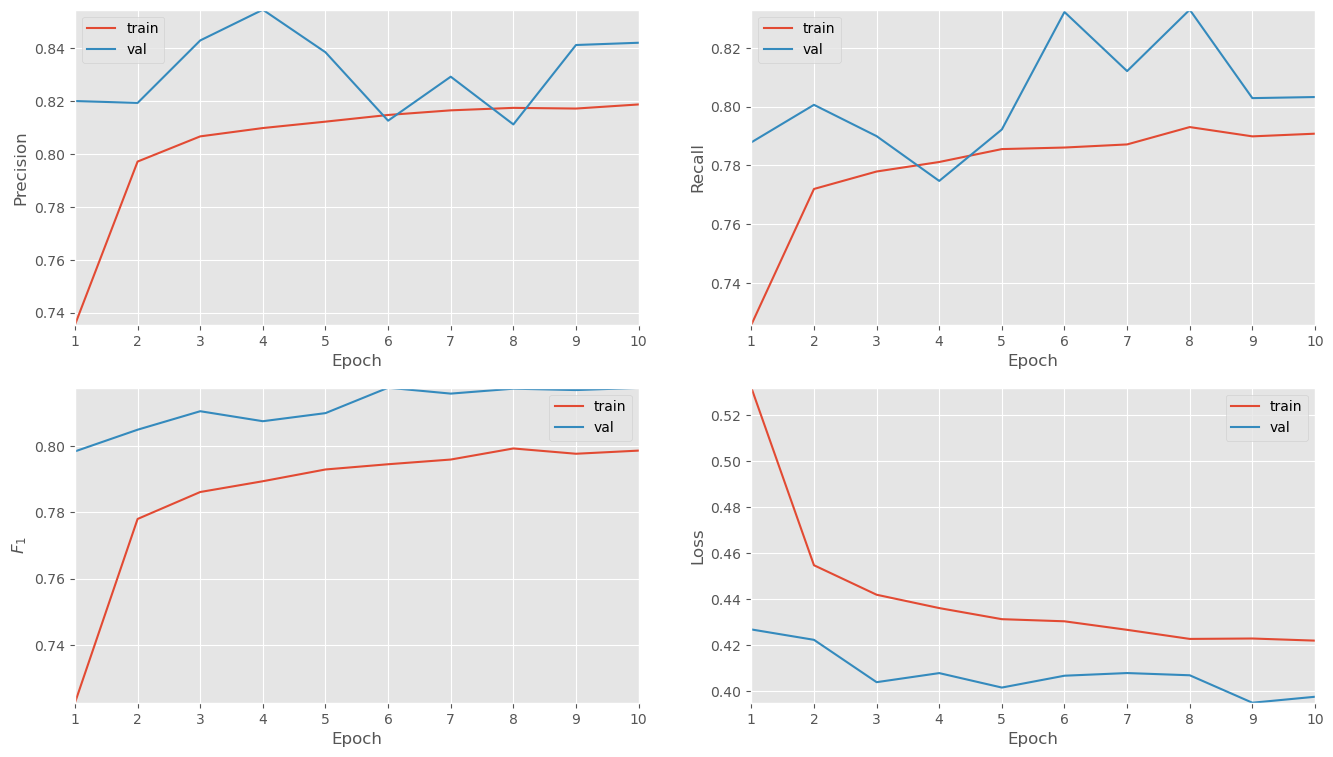

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()
    print(history.history['precision'])
    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [12]:
model.load_weights('cnn-frozen-embeddings-09-0.83.hdf5')

In [13]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     2000000     ['input_1[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 100, 200)     0           ['embedding[0][0]']              
                                                                                                  
 conv1d_10 (Conv1D)             (None, 99, 1)        401         ['dropout_2[0][0]']              
                                                                                            

C:\CONDA\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5",
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(np.array(x_train_seq), np.array(y_train), batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/5
2635/2635 [==============================] - 154s 57ms/step - loss: 0.4117 - precision: 0.8223 - recall: 0.7956 - f1: 0.8036 - val_loss: 0.3882 - val_precision: 0.8540 - val_recall: 0.8038 - val_f1: 0.8232
Epoch 2/5
2635/2635 [==============================] - 137s 52ms/step - loss: 0.4065 - precision: 0.8267 - recall: 0.7982 - f1: 0.8070 - val_loss: 0.3868 - val_precision: 0.8606 - val_recall: 0.7988 - val_f1: 0.8237
Epoch 3/5
2635/2635 [==============================] - 144s 55ms/step - loss: 0.4012 - precision: 0.8298 - recall: 0.8032 - f1: 0.8112 - val_loss: 0.3825 - val_precision: 0.8569 - val_recall: 0.8126 - val_f1: 0.8295
Epoch 4/5
2635/2635 [==============================] - 135s 51ms/step - loss: 0.3957 - precision: 0.8333 - recall: 0.8063 - f1: 0.8147 - val_loss: 0.3799 - val_precision: 0.8648 - val_recall: 0.7994 - val_f1: 0.8259
Epoch 5/5
2635/2635 [==============================] - 137s 52ms/step - loss: 0.3924 - precision: 0.8364 - recall: 0.8070 - f1: 0.8162 -

[0.8222613334655762, 0.8266808986663818, 0.8298174738883972, 0.8333330154418945, 0.8363919854164124]


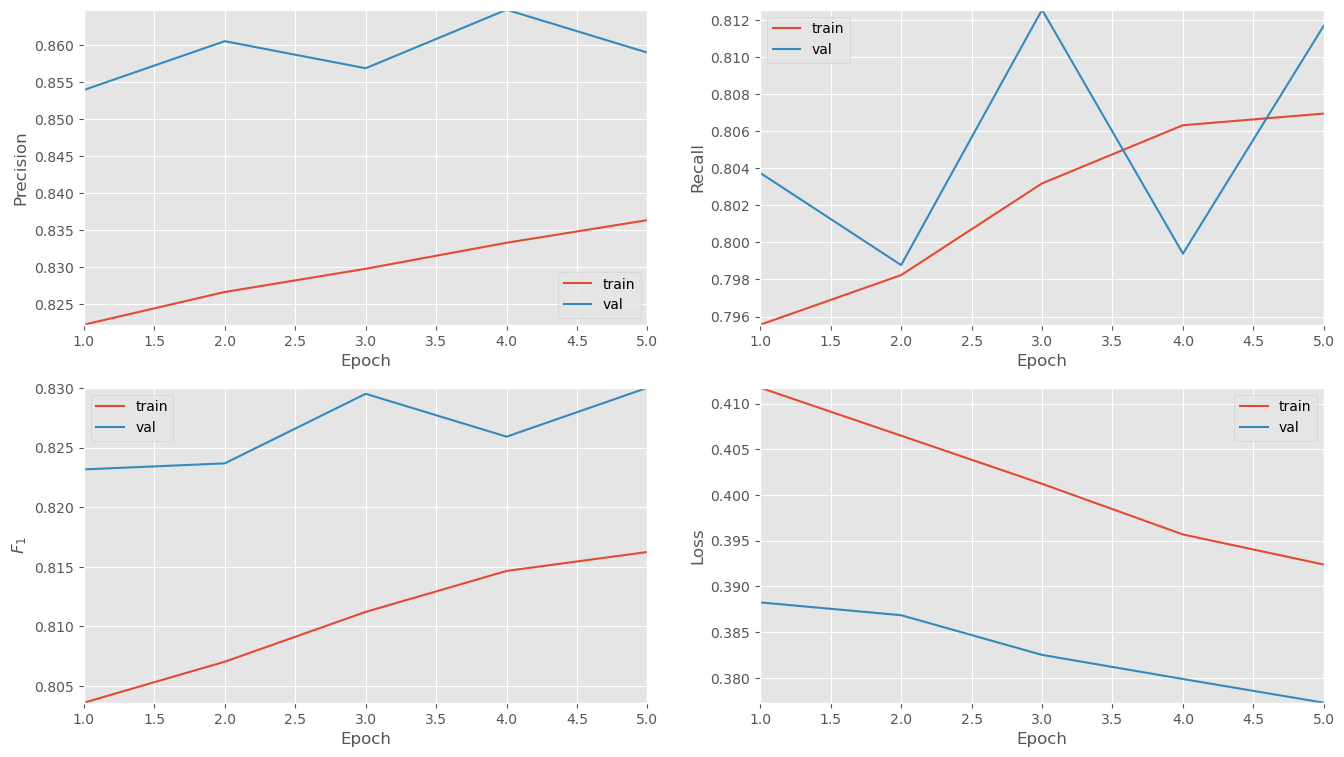

In [15]:
plot_history(history_trainable)

In [16]:
model.load_weights('cnn-trainable-05-0.83.hdf5')

In [17]:
data_test = pd.read_csv('data_test.csv', sep=',', error_bad_lines=False, usecols=['text',], encoding="Windows-1251")

sample_size = min(data_test.shape[0], 99999999)
print(data_test)
print(data_test.shape[0], data_test['text'].values)
raw_data = data_test['text'].values[:sample_size]
labels = [1] * sample_size + [0] * sample_size
data_t = [preprocess_text(t) for t in raw_data]
t_test = data_t
t_test_seq = get_sequences(tokenizer, t_test)
predicted = np.round(model.predict(t_test_seq))
print(*predicted)
i = 0
for reaction in predicted:
    if reaction[0] == 1:
        print("positive", data_test['text'].values[i])
    else:
        print("negative", data_test['text'].values[i])
    i += 1

C:\CONDA\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


                                                 text
0                              Очень понравился товар
1      Совсем не понравился! Хочется побольше функций
2   В целом неплохо. но если бы была возможность т...
3                       Отличная вещь. хорошо подошло
4                          Всем советую. очень хорошо
5                                              Супер!
6                                        Я тебя люблю
7                                      Хорошая погода
8                                            Не зашло
9                                            Так себе
10                                          Нормально
11                                     Бывало и лучше
12                                       Полное фуфло
13              Ну так в принципе ни хорошо. ни плохо
14                                          Прекрасно
15                Звучание. Оптимизация. Стабильность
16 ['Очень понравился товар' 'Совсем не понравился! Хочется побольше функций'
 'В 